# Network Intrusion Detection Using Supervised Machine Learning Techniques on Firewall Logs from a Nepalese ISP

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve,
    auc, ConfusionMatrixDisplay
)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Load datasets from Google Drive with existence check

df_attack = pd.read_csv('/content/drive/My Drive/Dataset2/With attack.csv')
df_normal = pd.read_csv('/content/drive/My Drive/Dataset2/Normal traffic.csv')

In [26]:
df_attack['label'] = 1
df_normal['label'] = 0

In [27]:
# Align and merge common columns
common_cols = df_attack.columns.intersection(df_normal.columns)
df_full = pd.concat([
    df_attack[common_cols],
    df_normal[common_cols]
], ignore_index=True)

In [28]:
# Remove duplicates
df_full.drop_duplicates(inplace=True)

# Drop sparse, leaky, or identifier columns
drop_cols = [
    'cluster_name', 'Container of app', 'UUID for rule', 'Characteristic of app',
    'Receive Time', 'High Res Timestamp', 'Source address', 'Destination address',
    'Threat/Content Type', 'Action'
]
df_full.drop(columns=drop_cols, inplace=True, errors='ignore')

In [29]:
# Encode categorical variables
for col in df_full.select_dtypes(include='object').columns:
    if col != 'label':
        df_full[col] = LabelEncoder().fit_transform(df_full[col])

# Remove constant features
constant_cols = [col for col in df_full.columns if df_full[col].nunique() <= 1]
df_full.drop(columns=constant_cols, inplace=True)

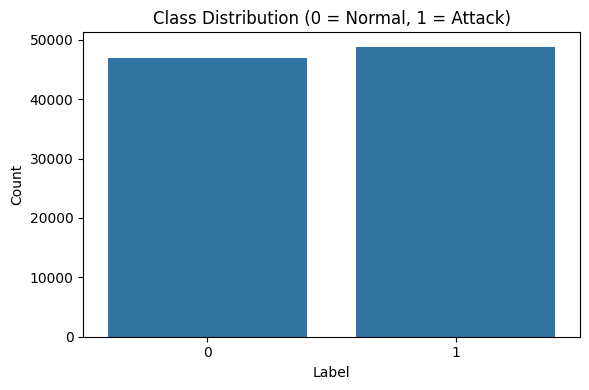

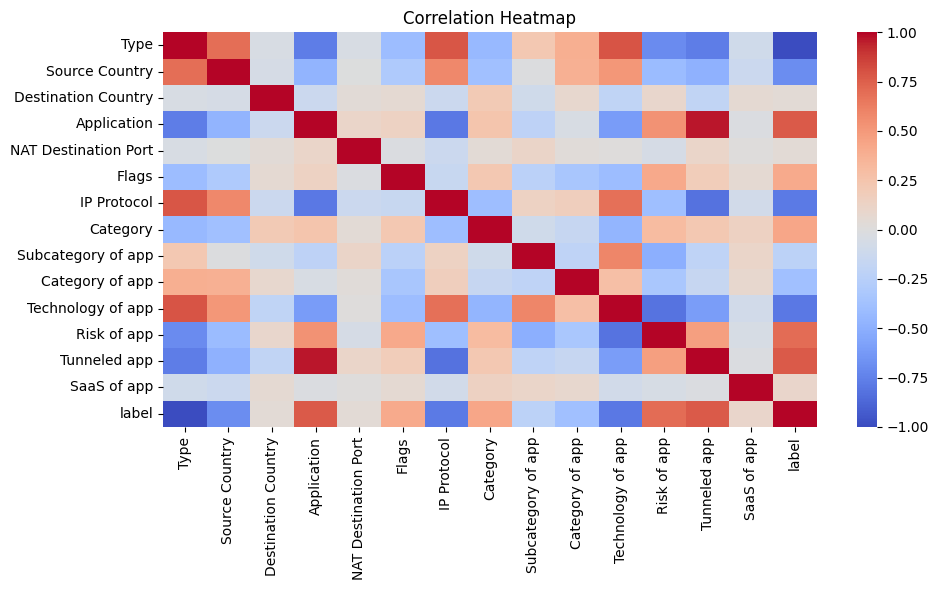

In [30]:
# Class distribution plot
plt.figure(figsize=(6, 4))
plt.clf()
sns.countplot(x='label', data=df_full)
plt.title('Class Distribution (0 = Normal, 1 = Attack)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
plt.savefig("class_distribution.png")
plt.close()

# Correlation heatmap
plt.figure(figsize=(10, 6))
plt.clf()
corr = df_full.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()
plt.savefig("correlation_heatmap.png")
plt.close()

In [31]:
# Create a balanced sample (5000 per class)
df_sampled = pd.concat([
    df_full[df_full['label'] == 1].sample(5000, random_state=42),
    df_full[df_full['label'] == 0].sample(5000, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Feature selection (top 7 non-leaky features)
X = df_sampled.drop(columns='label')
y = df_sampled['label']
selector = SelectKBest(score_func=f_classif, k=7)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()

# Remove overly predictive feature like 'Type' if present
selected_features = [f for f in selected_features if f != 'Type']
df_final = df_sampled[selected_features + ['label']]


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [32]:
# Save the clean dataset
df_final.to_csv("realistic_selected_features_dataset.csv", index=False)

In [33]:
# 5-fold cross-validation for realistic accuracy
X = df_final.drop(columns='label')
y = df_final['label']
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

In [34]:
cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results.append([name, scores.mean(), scores.std()])
pd.DataFrame(cv_results, columns=["Model", "Mean Accuracy (CV)", "Std Dev"]).to_csv("cv_model_accuracy_summary.csv", index=False)

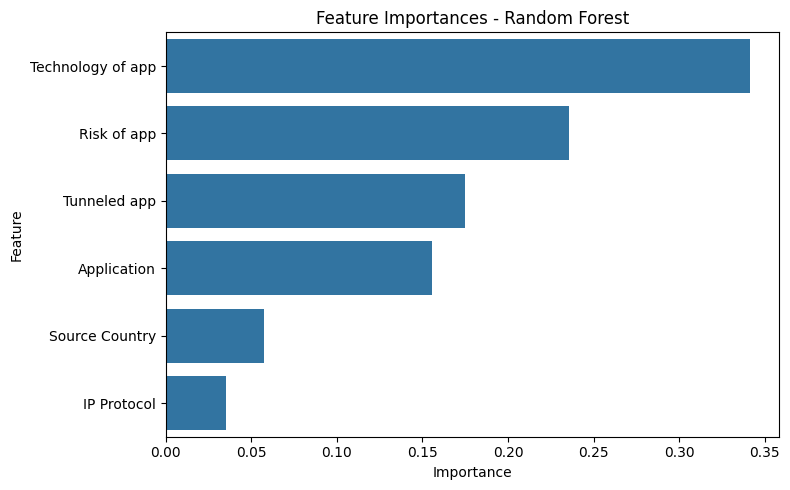

In [35]:
# Train Random Forest to plot feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()
plt.savefig("feature_importances_rf.png")
plt.close()


In [ ]:
# ROC curve for Random Forest
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
rf_model.fit(X_train, y_train)
y_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Random Forest AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
plt.savefig("roc_curve_rf.png")
plt.close()

In [ ]:
# ROC curve for Random Forest
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Random Forest ROC
rf_model.fit(X_train, y_train)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest AUC = {roc_auc_rf:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
plt.savefig("roc_curve_rf.png")
plt.close()

In [ ]:
# Logistic Regression ROC
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label=f"LogReg AUC = {roc_auc_lr:.2f}", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
plt.savefig("roc_curve_lr.png")
plt.close()

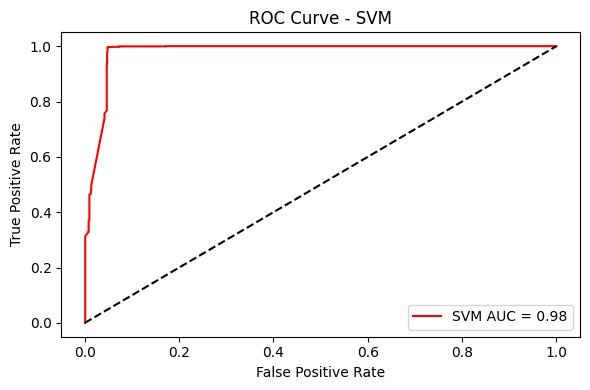

In [39]:
# SVM ROC
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(6, 4))
plt.plot(fpr_svm, tpr_svm, label=f"SVM AUC = {roc_auc_svm:.2f}", color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
plt.savefig("roc_curve_svm.png")
plt.close()

In [40]:
# Confusion Matrix Heatmaps
from sklearn.metrics import confusion_matrix
import seaborn as sns

models_preds = [
    ("Random Forest", rf_model.predict(X_test)),
    ("Logistic Regression", lr_model.predict(X_test)),
    ("SVM", y_pred_svm)
]

for name, y_pred in models_preds:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"confusion_matrix_{name.lower().replace(' ', '_')}.png")
    plt.close()

NameError: name 'y_pred_svm' is not defined